Using Detectron2 for faster and fair comparison

In [1]:
import random
import os
from math import ceil
import logging

import cv2
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.solver import WarmupCosineLR
from detectron2.utils.comm import is_main_process
from torch.optim import Adam

import matplotlib.pyplot as plt

In [2]:
train_image_path = '/home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/images/train'
train_json_path = f'{train_image_path}/annotations.json'
test_image_path = '/home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/images/test'
test_json_path = f'{test_image_path}/annotations.json'
valid_image_path = '/home/xiang/Desktop/Data_Mining/project/data/ASLv1/processed_yolo11/images/valid'
valid_json_path = f'{valid_image_path}/annotations.json'
register_coco_instances("asl_train", {}, train_json_path, train_image_path)
register_coco_instances("asl_val", {}, valid_json_path, valid_image_path)
register_coco_instances("asl_test", {}, test_json_path, test_image_path)

In [3]:
# Retrieve the registered dataset
dataset = DatasetCatalog.get("asl_train")

# Get the dataset size
dataset_size = len(dataset)
print(dataset_size)

15110


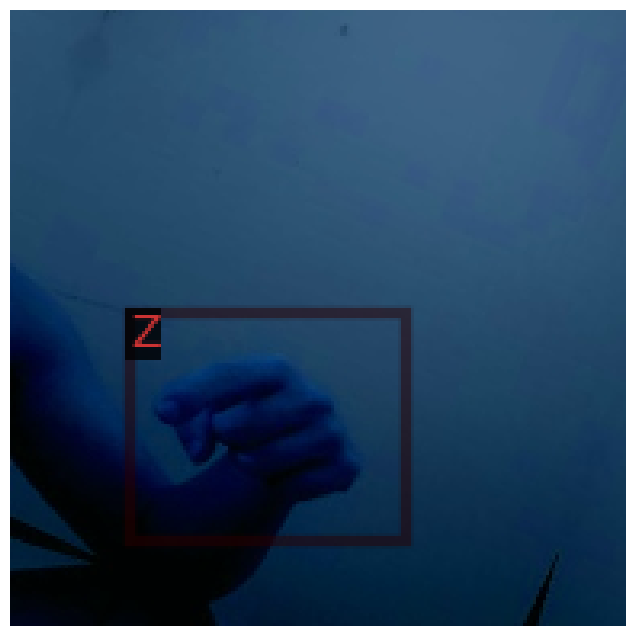

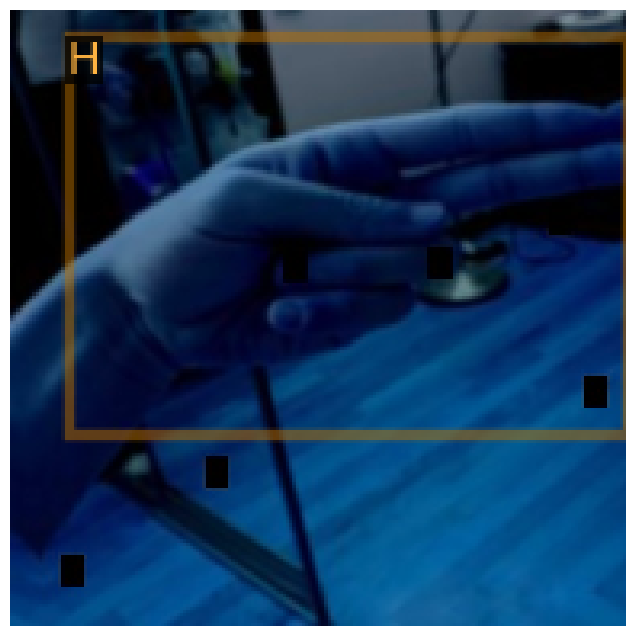

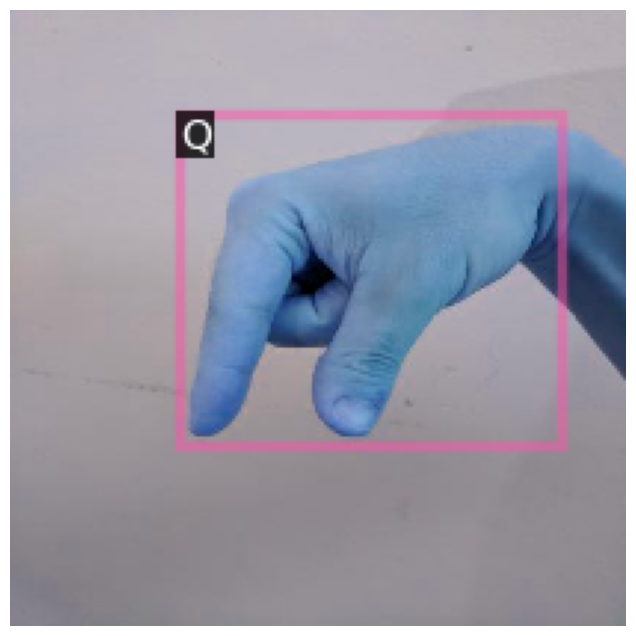

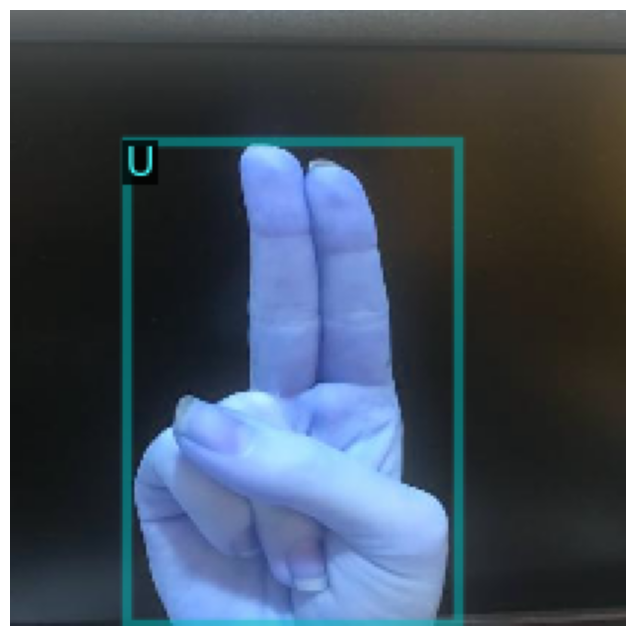

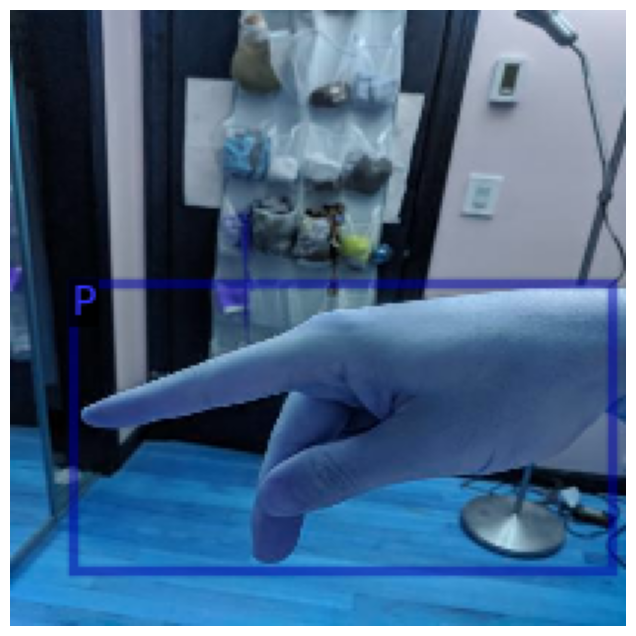

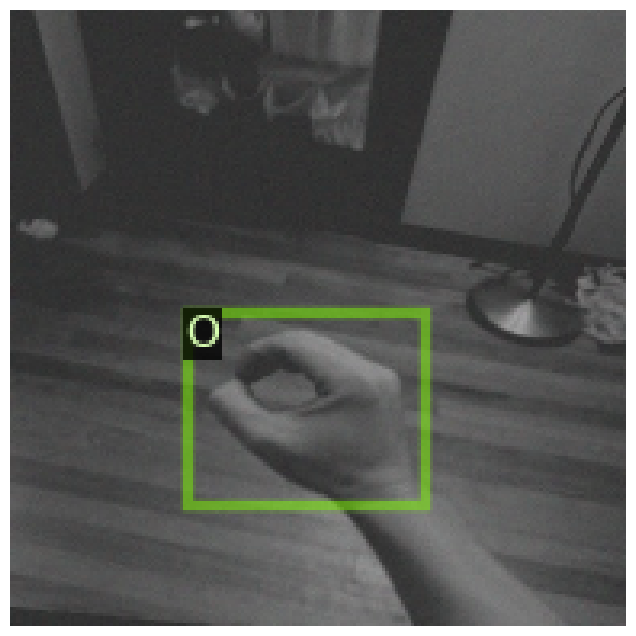

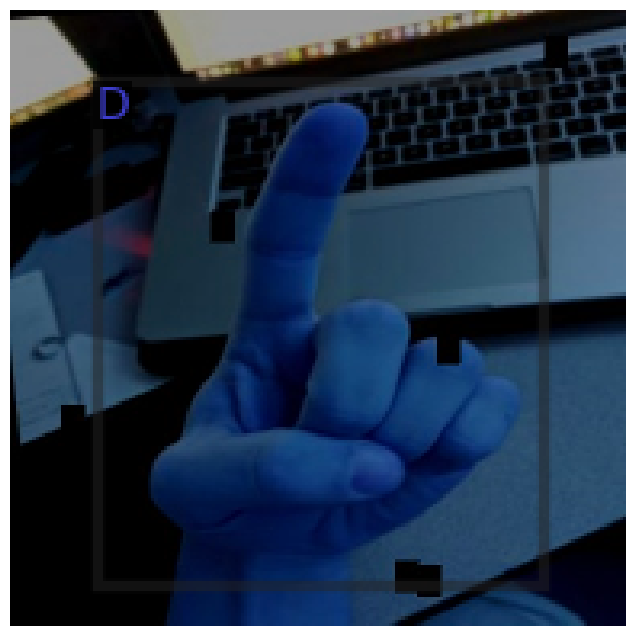

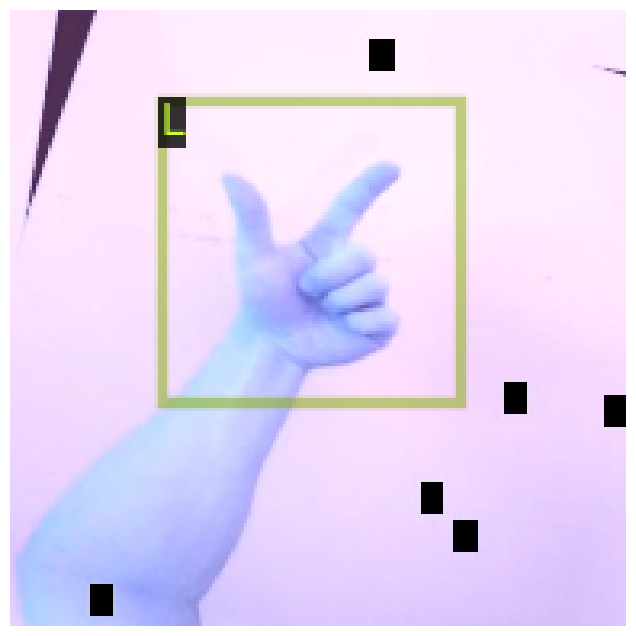

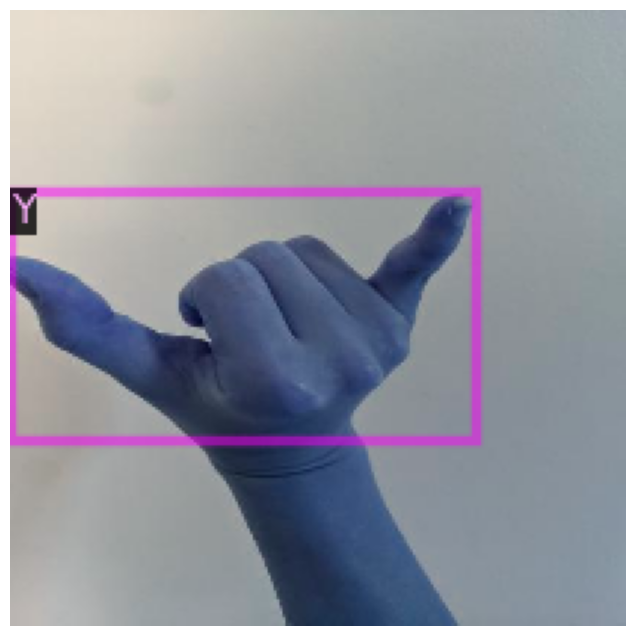

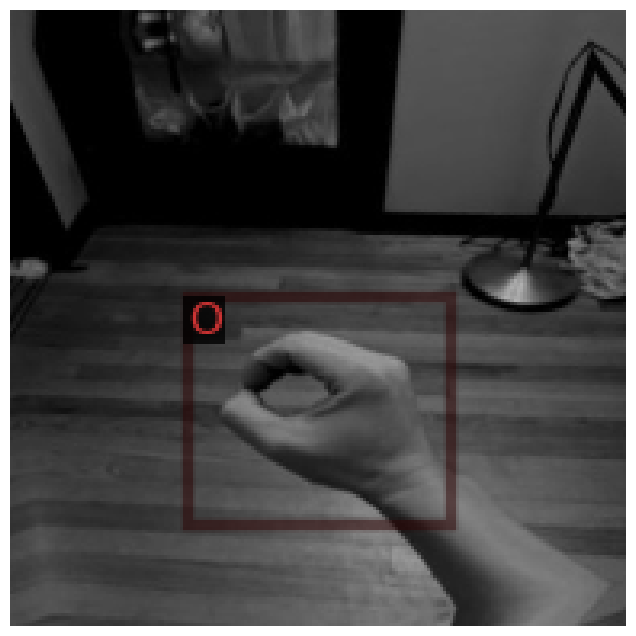

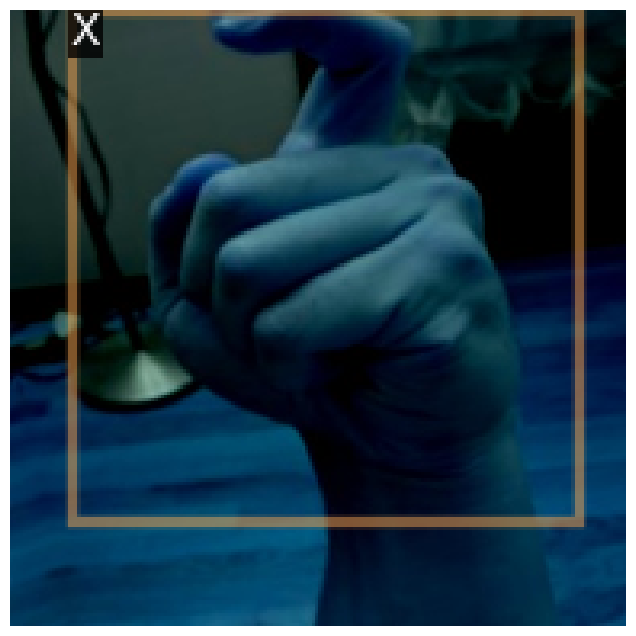

In [5]:
dataset_dicts = DatasetCatalog.get("asl_val")
asl_metadata = MetadataCatalog.get("asl_val")

for d in random.sample(dataset_dicts, 11):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=asl_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    # Convert image to RGB (from BGR)
    img_rgb = vis.get_image()[:, :, ::-1]
    # Display using Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

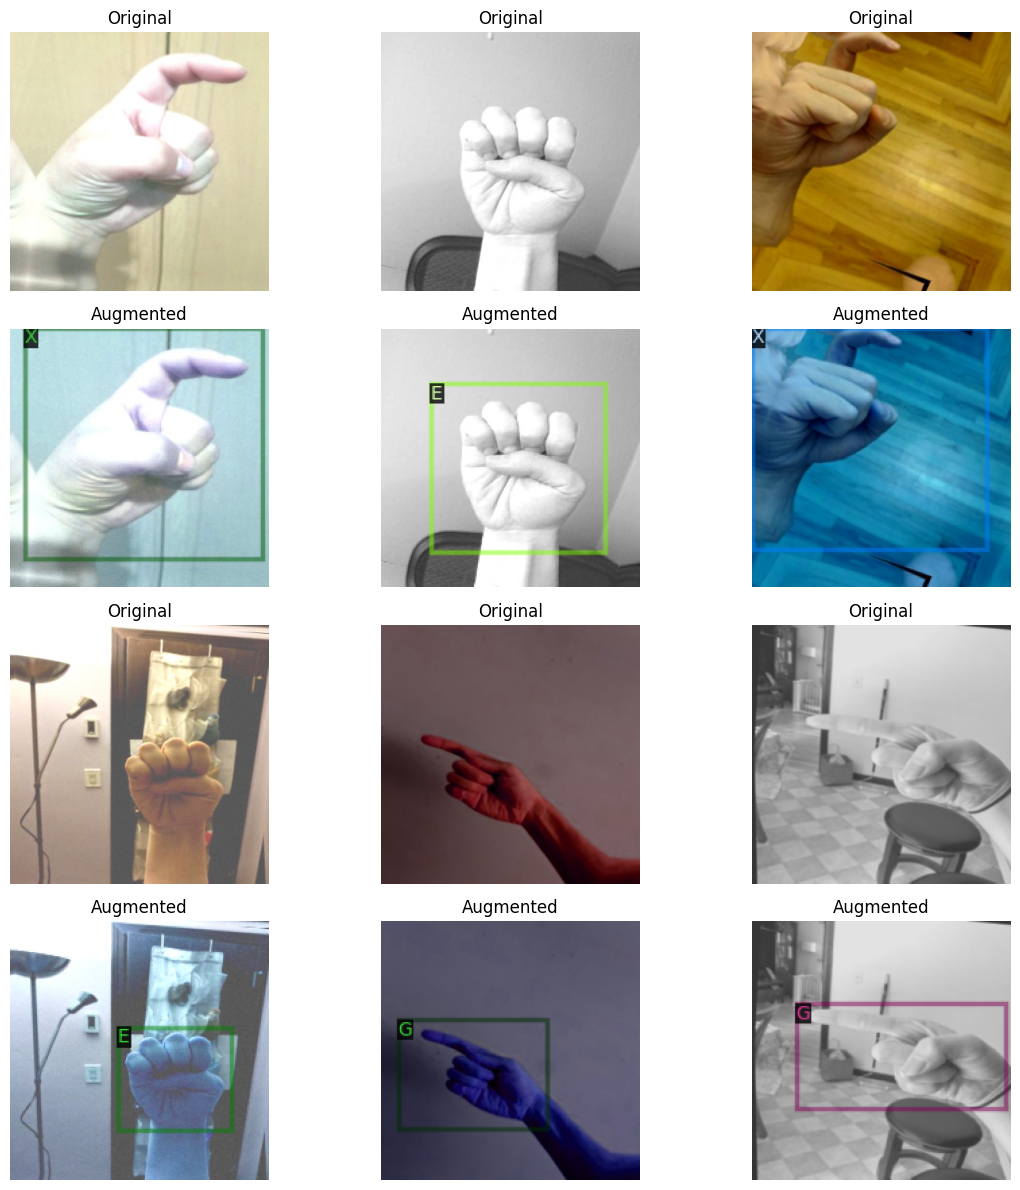

In [23]:
# Sample images and create a grid
def show_image_grid(dataset_dicts, num_samples=6):
    sampled_data = random.sample(dataset_dicts, num_samples)
    fig, axs = plt.subplots(4, int(num_samples / 2), figsize=(12, 12))

    for idx in range(int(num_samples / 2)):
        d = sampled_data[idx]
        # Read original image
        img = cv2.imread(d["file_name"])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Visualize augmented version
        visualizer = Visualizer(img[:, :, ::-1],
                                metadata=asl_metadata,
                                scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        augmented_img = vis.get_image()[:, :, ::-1]

        # Display original image
        axs[0, idx].imshow(img_rgb)
        axs[0, idx].axis('off')
        axs[0, idx].set_title("Original")

        # Display augmented image
        axs[1, idx].imshow(augmented_img)
        axs[1, idx].axis('off')
        axs[1, idx].set_title("Augmented")

        d = sampled_data[idx + int(num_samples / 2)]
        vis = visualizer.draw_dataset_dict(d)
        augmented_img = vis.get_image()[:, :, ::-1]
        img = cv2.imread(d["file_name"])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Visualize augmented version
        visualizer = Visualizer(img[:, :, ::-1],
                                metadata=asl_metadata,
                                scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        augmented_img = vis.get_image()[:, :, ::-1]
        # Display original image
        axs[2, idx].imshow(img_rgb)
        axs[2, idx].axis('off')
        axs[2, idx].set_title("Original")

        # Display augmented image
        axs[3, idx].imshow(augmented_img)
        axs[3, idx].axis('off')
        axs[3, idx].set_title("Augmented")

    plt.tight_layout()
    plt.show()


# Call the function to display the grid
show_image_grid(dataset_dicts)

In [13]:
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 32
    DATASET_SIZE = dataset_size
    LR = 0.001
    MAX_ITER = ceil(dataset_size / BATCH_SIZE) * NUM_EPOCHS
    EVAL_PERIOD = ceil(dataset_size / BATCH_SIZE)
    PIXEL = 384


cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("asl_train", )
cfg.DATASETS.TEST = ("asl_val", )  # Set validation dataset here
cfg.DATALOADER.NUM_WORKERS = 12

cfg.INPUT.MIN_SIZE_TRAIN = Config.PIXEL
cfg.INPUT.MAX_SIZE_TRAIN = Config.PIXEL
cfg.INPUT.MIN_SIZE_TEST = Config.PIXEL
cfg.INPUT.MAX_SIZE_TEST = Config.PIXEL

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 26  # Number of classes (A-Z)
# to speed up the model training, adjust the model structure
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128]]  # [[32, 64, 128, 256, 512]]
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[1.0]]  # Square anchors only [[0.5, 1.0, 2.0]]
cfg.MODEL.FPN.OUT_CHANNELS = 128  # 256

cfg.SOLVER.IMS_PER_BATCH = Config.BATCH_SIZE
cfg.SOLVER.BASE_LR = Config.LR
cfg.SOLVER.MAX_ITER = Config.MAX_ITER
cfg.SOLVER.WARMUP_ITERS = 1000  # Warmup iterations
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 3.0
cfg.SOLVER.WARMUP_METHOD = "linear"  # Warmup method
cfg.SOLVER.WEIGHT_DECAY = 0.0001  # Weight decay

# Set evaluation period (e.g., every 100 iterations)
cfg.TEST.EVAL_PERIOD = Config.EVAL_PERIOD

cfg.OUTPUT_DIR = './detectron_output'
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "faster_RCNN_model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set threshold

In [ ]:
class EvalHook(HookBase):
    """
    Hook for evaluating mAP during training.
    """

    def __init__(self, eval_period, eval_function):
        self._eval_period = eval_period
        self._eval_function = eval_function

    def after_step(self):
        """
        Evaluate the model periodically after a specific number of iterations.
        """
        if self.trainer.iter % self._eval_period == 0 and is_main_process():
            logging.info("Running evaluation...")
            results = self._eval_function()
            self.trainer.storage.put_scalars(**results)


class CustomTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name,
                             cfg,
                             False,
                             output_dir="./detectron_output/")

    def build_hooks(self):
        """
        Add hooks to include periodic evaluation during training.
        """
        hooks = super().build_hooks()
        if self.cfg.TEST.EVAL_PERIOD > 0:
            # Insert periodic evaluation hook
            hooks.insert(
                -1,  # Insert before the final hook
                EvalHook(
                    self.cfg.TEST.EVAL_PERIOD,
                    lambda: self.test(self.cfg, self.model),
                ),
            )
        return hooks

    @classmethod
    def build_optimizer(cls, cfg, model):
        return Adam(
            model.parameters(),
            lr=cfg.SOLVER.BASE_LR,
            weight_decay=cfg.SOLVER.WEIGHT_DECAY,
        )

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        return WarmupCosineLR(
            optimizer,
            max_iters=cfg.SOLVER.MAX_ITER,
            warmup_factor=cfg.SOLVER.WARMUP_FACTOR,
            warmup_iters=cfg.SOLVER.WARMUP_ITERS,
            warmup_method=cfg.SOLVER.WARMUP_METHOD,
        )

    def test(self, cfg, model, evaluators=None):
        if evaluators is None:
            evaluators = [
                self.build_evaluator(cfg, name) for name in cfg.DATASETS.TEST
            ]
        results = {}
        for idx, dataset_name in enumerate(cfg.DATASETS.TEST):
            data_loader = build_detection_test_loader(cfg, dataset_name)
            result = inference_on_dataset(model, data_loader, evaluators[idx])
            results[dataset_name] = result
        return results

In [7]:
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/30 20:44:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'backbone.fpn_lateral2.weight' to the model due to incompatible shapes: (256, 256, 1, 1) in the checkpoint but (128, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral2.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (128,) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_output2.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (128, 128, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_output2.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (128,) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral3.weight' to the model due to incompatible shapes: (256, 512, 1, 1) in the checkpoint but (128, 512, 1, 1) in the model! You might wan

[11/30 20:44:58 d2.engine.train_loop]: Starting training from iteration 0


/home/xiang/han/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/30 20:45:16 d2.utils.events]:  eta: 1:42:31  iter: 19  total_loss: 1.545  loss_cls: 0.3654  loss_box_reg: 0.1981  loss_rpn_cls: 0.5232  loss_rpn_loc: 0.4962    time: 0.8636  last_time: 0.8446  data_time: 0.0413  last_data_time: 0.0209   lr: 0.00034599  max_mem: 4044M


2024-11-30 20:45:16.371966: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 20:45:16.399165: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 20:45:16.399200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 20:45:16.399221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 20:45:16.404939: I tensorflow/core/platform/cpu_feature_g

[11/30 20:45:34 d2.utils.events]:  eta: 1:39:48  iter: 39  total_loss: 1.346  loss_cls: 0.3264  loss_box_reg: 0.2353  loss_rpn_cls: 0.3789  loss_rpn_loc: 0.3977    time: 0.8281  last_time: 0.8550  data_time: 0.0227  last_data_time: 0.0265   lr: 0.00035931  max_mem: 4044M
[11/30 20:45:51 d2.utils.events]:  eta: 1:40:01  iter: 59  total_loss: 1.335  loss_cls: 0.3718  loss_box_reg: 0.2766  loss_rpn_cls: 0.2704  loss_rpn_loc: 0.4047    time: 0.8378  last_time: 0.8645  data_time: 0.0262  last_data_time: 0.0240   lr: 0.0003726  max_mem: 4044M
[11/30 20:46:08 d2.utils.events]:  eta: 1:40:11  iter: 79  total_loss: 1.314  loss_cls: 0.4308  loss_box_reg: 0.3127  loss_rpn_cls: 0.1767  loss_rpn_loc: 0.3834    time: 0.8446  last_time: 0.8630  data_time: 0.0265  last_data_time: 0.0251   lr: 0.00038588  max_mem: 4044M
[11/30 20:46:25 d2.utils.events]:  eta: 1:40:06  iter: 99  total_loss: 1.225  loss_cls: 0.407  loss_box_reg: 0.2898  loss_rpn_cls: 0.1616  loss_rpn_loc: 0.3654    time: 0.8484  last_tim